In [1]:
include("../../src/CoherentStructures.jl") #this is terrible but neccessary during development (?)

Main.CoherentStructures

In [2]:
using StreamMacros, Main.CoherentStructures
using Tensors, Arpack, Distances
using Plots

In [3]:
# Parameters
grid_resolution        = 100
quadrature_order       = 2
selected_ev            = 2;      # which Eigenvector to choose
ϵ                      = 0.5     # perturbation
a                      = 0.98;   # parameter value corresponding to ϵ=0

In [4]:
T(x ,p) = [rem2pi(x[1] + x[2] + (a+p)*sin(x[1]), RoundDown),
           rem2pi(       x[2] + (a+p)*sin(x[1]), RoundDown)]

T (generic function with 1 method)

In [5]:
LL, UR = (0.0, 0.0), (2π, 2π)
ctx, _ = regularTriangularGrid((grid_resolution, grid_resolution), LL, UR, quadrature_order = quadrature_order)
pred(x,y) = peuclidean(x, y, [2π, 2π]) < 1e-9
bdata = BoundaryData(ctx, pred);

In [6]:
M = assembleMassMatrix(ctx, bdata=bdata);

In [7]:
@time D⁰ = assembleStiffnessMatrix(ctx, bdata=bdata)
@time D¹ = adaptiveTOCollocationStiffnessMatrix(ctx, y -> T(y,0), bdata=bdata, on_torus=true)
K = 0.5(D⁰+D¹);

  0.514501 seconds (1.33 M allocations: 79.463 MiB, 4.05% gc time)
  6.842938 seconds (23.91 M allocations: 1.686 GiB, 6.92% gc time)


In [8]:
# solve the linear system
@time λ₀, u₀ = eigs(K, M, which=:SM)
@assert all(imag.(u₀) .== 0)
@assert all(imag.(λ₀) .== 0)
u₀ = real.(u₀[:,selected_ev])
λ₀ = real.(λ₀[selected_ev])
u₀ = u₀ ./ sqrt(u₀'*M*u₀)        # L2 normalization
u₀ = u₀*sign(sum(u₀))            # fix sign
λ₀

  3.532544 seconds (9.11 M allocations: 513.060 MiB, 5.49% gc time)


-1.103489959199448

In [9]:
# assemble the linear response matrix L
@time L = adaptiveTOCollocationLinearResponseMatrix(ctx, T, 0, bdata=bdata, on_torus=true);

  4.950661 seconds (23.57 M allocations: 1.847 GiB, 12.17% gc time)


In [10]:
# solve the system for the derivative u_dot
lhs = [K-λ₀*M   -M*u₀
        u₀'*M      0]
rhs = [-L*u₀    ;  0]

@time b = lhs \ rhs
u_dot = b[1:end-1]
λ_dot = b[end]

  0.767486 seconds (2.43 M allocations: 146.773 MiB, 3.55% gc time)


-0.22325800191376868

In [11]:
# calculate the exact uϵ
D¹ϵ = adaptiveTOCollocationStiffnessMatrix(ctx, y -> T(y,ϵ),bdata=bdata, on_torus=true)
Kϵ = 0.5(D⁰+D¹ϵ);
λϵ, uϵ = eigs(Kϵ, M, which=:SM)
@assert all(imag.(uϵ) .== 0)
@assert all(imag.(λϵ) .== 0)
uϵ = real.(uϵ[:,selected_ev])
λϵ = real.(λϵ[selected_ev])
uϵ = uϵ ./ sqrt(uϵ'*M*uϵ)
uϵ = uϵ*sign(sum(uϵ))
λϵ

-1.2487337505173286

In [12]:
λ₀ + ϵ*λ_dot

-1.2151189601563324

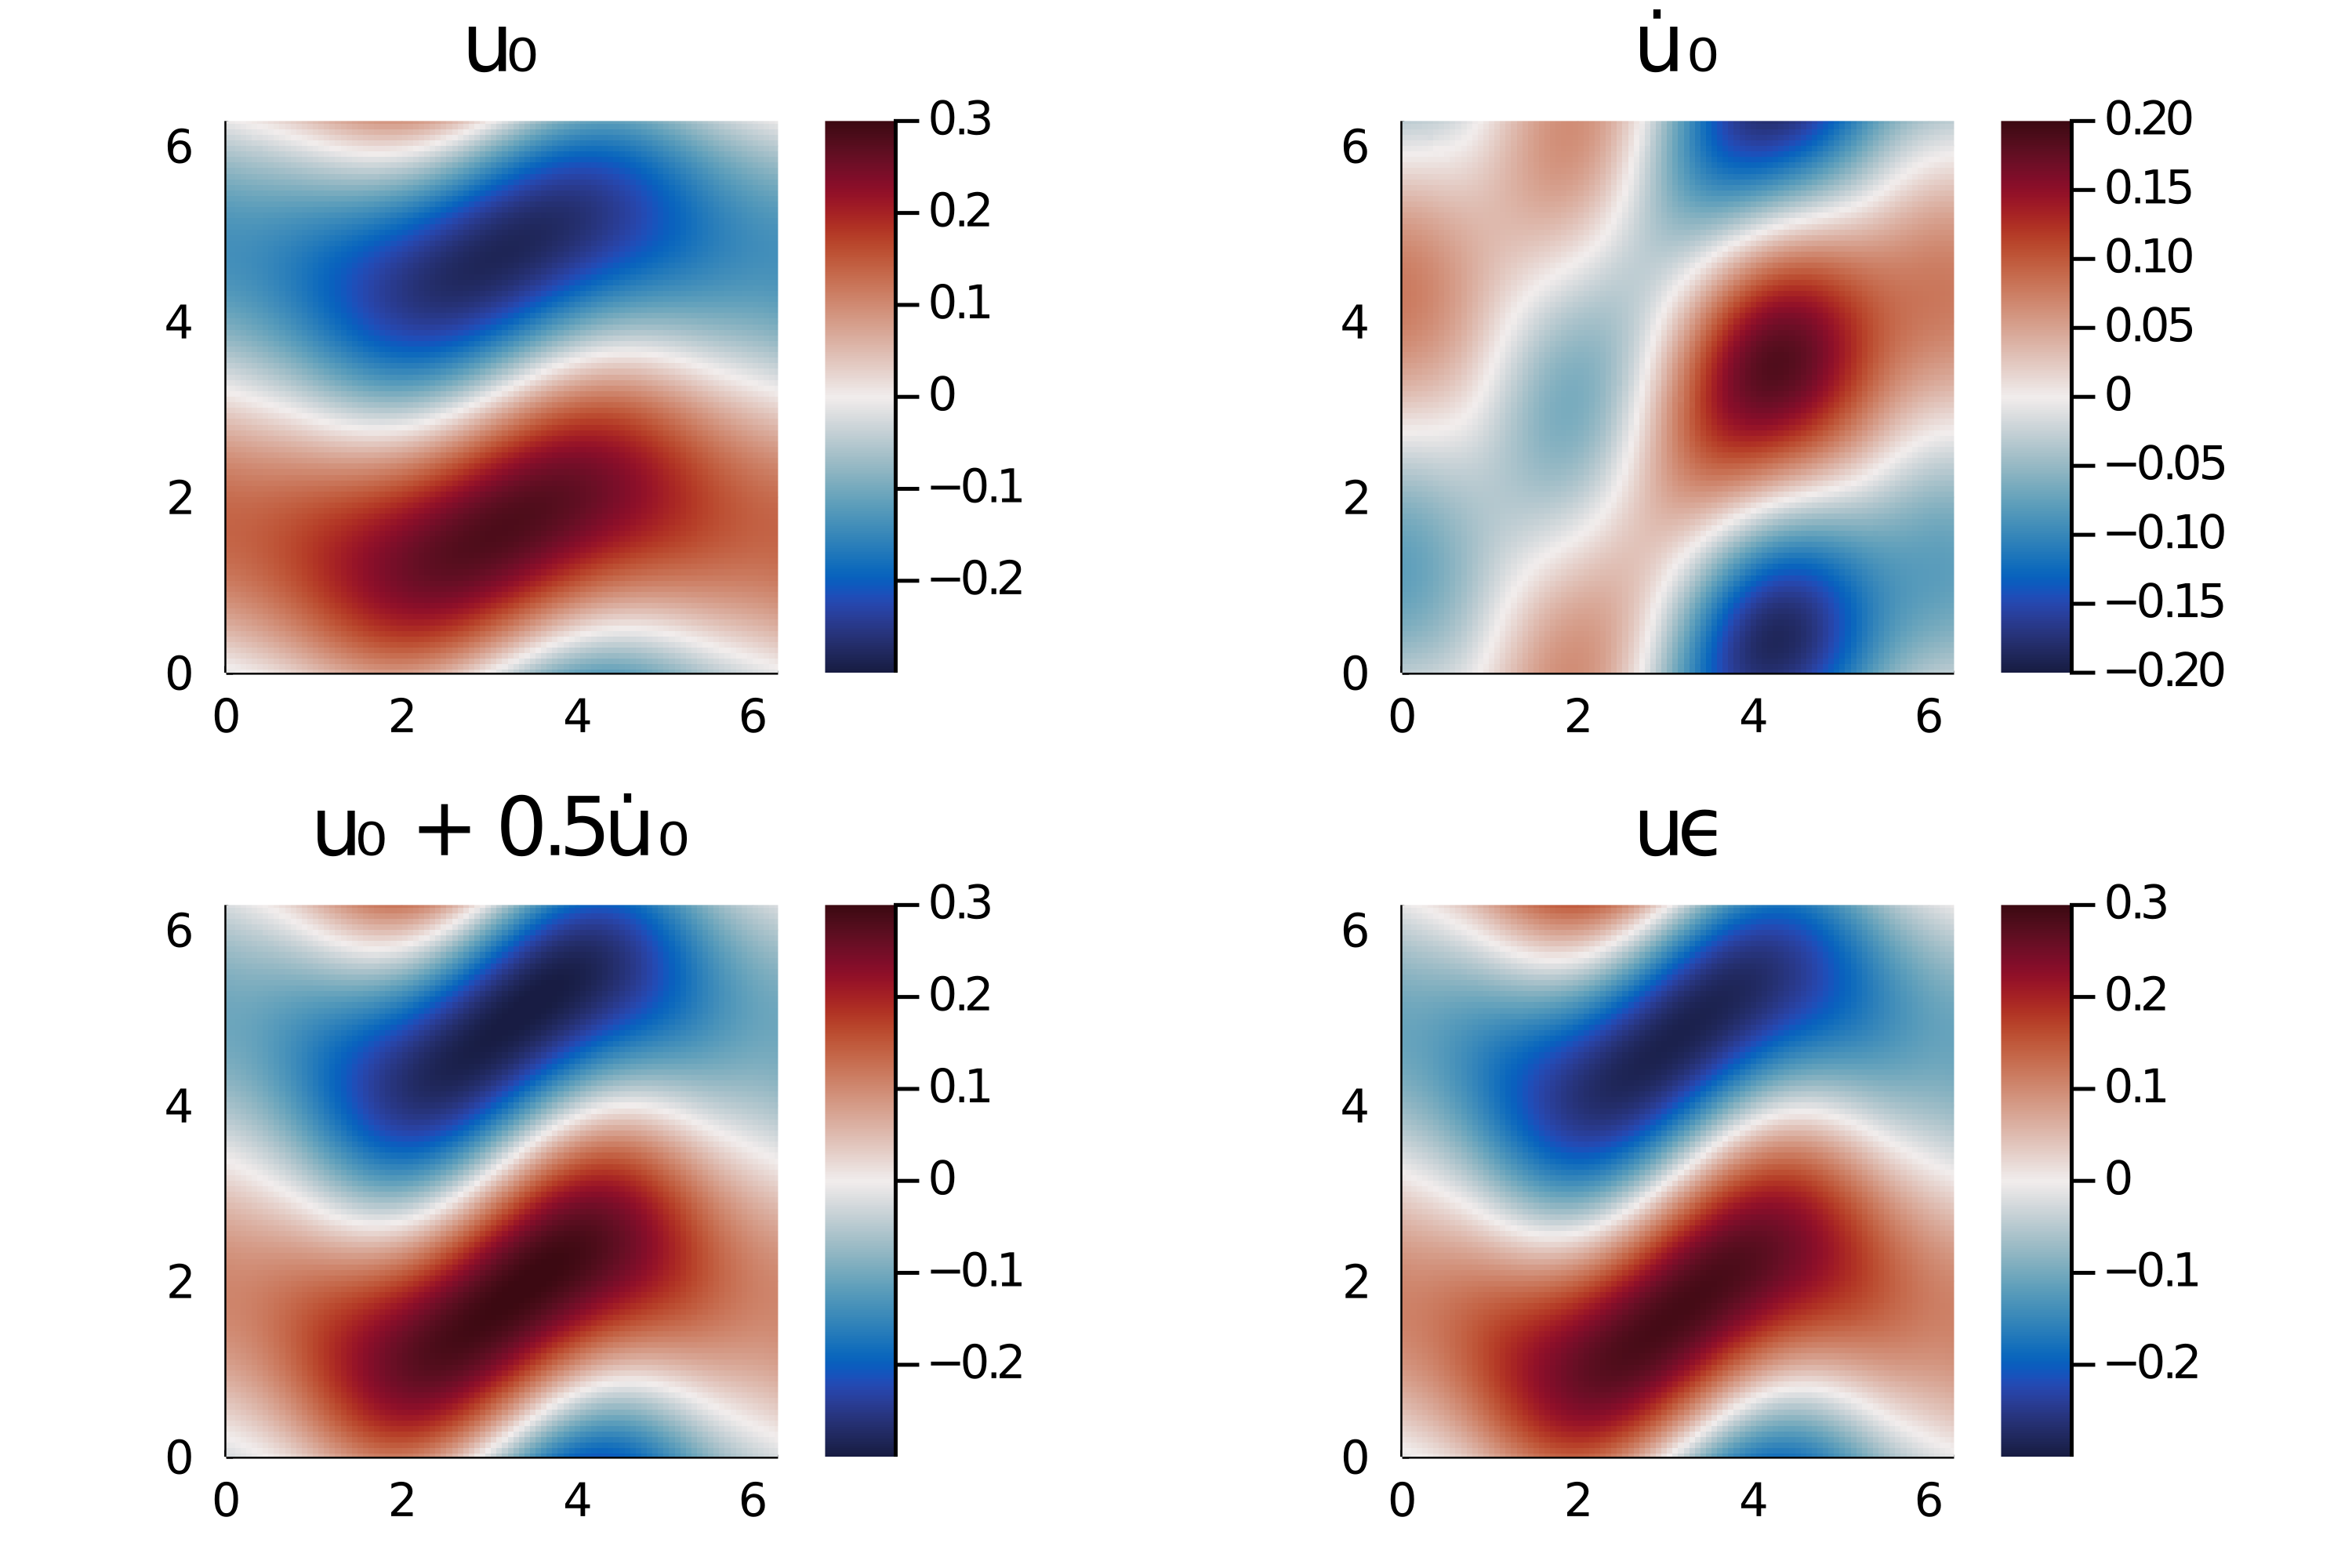

In [13]:
color =    :balance
xticks =   0:2:6
yticks =   0:2:6
colorbar = :left
cmin =     -0.3
cmax =     0.3
cmin_lr =  -0.2
cmax_lr =  0.2
#unfortunately there is no option for colorbar ticks


original      = plot_u(ctx, u₀,  grid_resolution, grid_resolution, title="u₀", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
derivative    = plot_u(ctx, u_dot,       grid_resolution, grid_resolution, title="u̇ ₀", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin_lr,cmax_lr), xticks=xticks, yticks=yticks)
extrapolated  = plot_u(ctx, u₀ + ϵ*u_dot, grid_resolution, grid_resolution, title="u₀ + $(ϵ)u̇ ₀", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
exact         = plot_u(ctx, uϵ,          grid_resolution, grid_resolution, title="uϵ", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
Plots.plot(original,derivative,extrapolated,exact, fmt=:png, dpi=500)

In [14]:
using Contour
using StaticArrays

In [15]:
#Contour.jl needs StaticArrays
T_static(x) = SVector{2,Float64}(T(x,0))

T_static (generic function with 1 method)

In [16]:
function dynamic_cheeger_value_levelset(levelset)
    curves = lines(levelset)
    if length(curves) != 1 
        @warn "Currently only connected levelsets are allowed! Levelset: ", level(levelset)
    end
    curve = curves[1]
    return dynamic_cheeger_value(ctx,curve,T_static,tolerance=1e-10)
end
function dynamic_cheeger_value_levelset_nonnegative(levelset)
    if level(levelset) < 0
        return Inf
    end
    curves = lines(levelset)
    if length(curves) != 1 
        @warn "Currently only connected levelsets are allowed! Levelset: $(level(levelset))"
    end
    curve = curves[1]
    return dynamic_cheeger_value(ctx,curve,T_static,tolerance=1e-10)
end

best_levelset, best_value = get_minimal_levelset(
    ctx,u₀,dynamic_cheeger_value_levelset_nonnegative,n_candidates=1000,bdata=bdata)
print("Dynamic Cheeger value:\t",best_value,"\n")
print("Levelset:\t\t",level(best_levelset),"\n")

┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.00016970468223653778
└ @ Main In[16]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.0007392238954169739
└ @ Main In[16]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.00130874310859741
└ @ Main In[16]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.0018782623217777905
└ @ Main In[16]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.0024477815349582266
└ @ Main In[16]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.0030173007481386627
└ @ Main In[16]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.0035868199613190987
└ @ Main In[16]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.004156339174499479
└ @ Main In[16]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.004725858387679915
└ @ Main In[16]:15
┌ Warning: Cu

┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.05199595308165483
└ @ Main In[16]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.05256547229483527
└ @ Main In[16]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.053134991508015705
└ @ Main In[16]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.053704510721196086
└ @ Main In[16]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.05427402993437652
└ @ Main In[16]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.05484354914755696
└ @ Main In[16]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.055413068360737394
└ @ Main In[16]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.055982587573917775
└ @ Main In[16]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.05655210678709821
└ @ Main In[16]:15
┌ Warning: Currently onl

┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.104961239907434
└ @ Main In[16]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.10553075912061438
└ @ Main In[16]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.10610027833379482
└ @ Main In[16]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.10666979754697525
└ @ Main In[16]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.10723931676015569
└ @ Main In[16]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.10780883597333607
└ @ Main In[16]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.1083783551865165
└ @ Main In[16]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.10894787439969694
└ @ Main In[16]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.10951739361287732
└ @ Main In[16]:15
┌ Warning: Currently only conne

Dynamic Cheeger value:	1.8048423656545536
Levelset:		0.20234902536128596


cheeger value		length			length transported	volume
2.073324313794124	13.15432199107651	24.79461722947993	9.151713257804557
1.8048423656545536	9.113541262835204	7.9822127955706765	4.7360795556807105


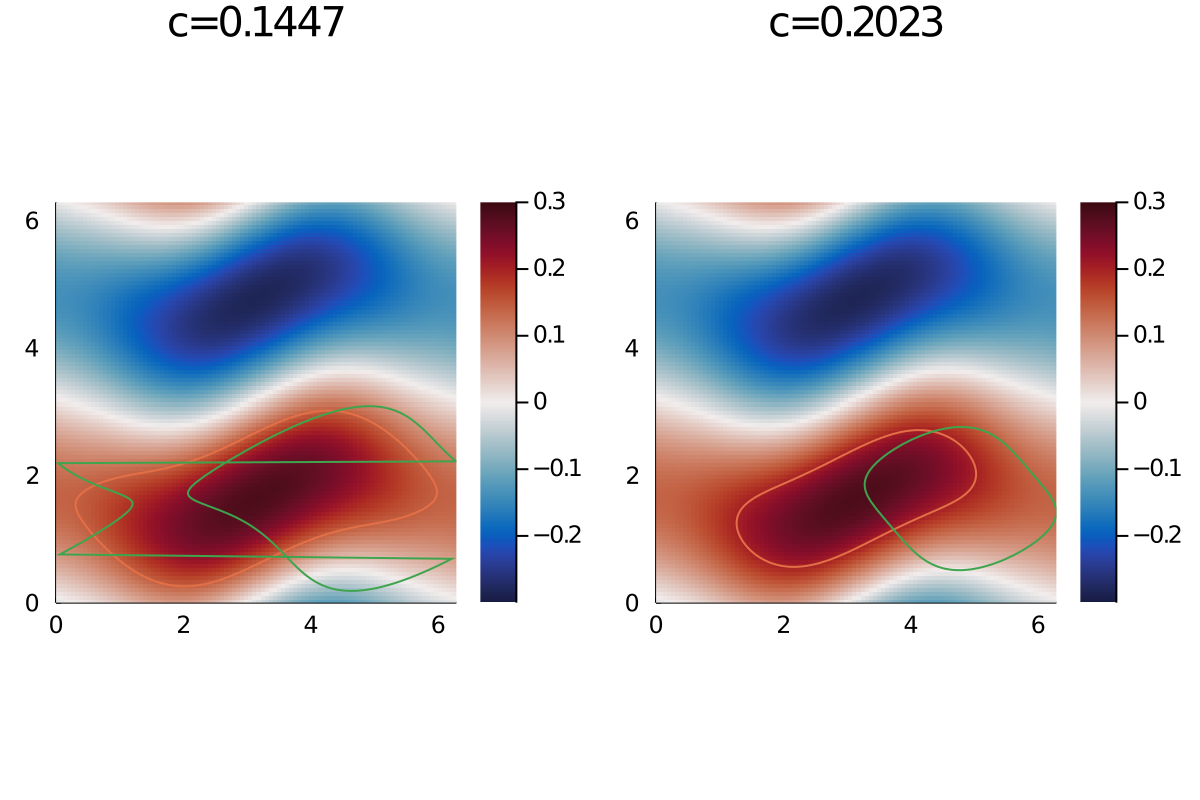

In [17]:
# value from paper
c_paper = 0.1447
plot_paper = plot_u(ctx, u₀,  grid_resolution, grid_resolution, title="c=$(round(c_paper,digits=4))",bdata=bdata,
        colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks,legend=false)

curves = lines(get_levelset(ctx, u₀, c_paper, bdata=bdata))
curves_moved = [Main.CoherentStructures.apply2curve(T_static,c) for c in curves]

cheeger_value = dynamic_cheeger_value(ctx, curves[1], T_static)
print("cheeger value\t\tlength\t\t\tlength transported\tvolume\n")
print("$(cheeger_value)\t$(Main.CoherentStructures.getLength(curves[1]))\t",
    "$(Main.CoherentStructures.getLength(curves_moved[1]))\t$(Main.CoherentStructures.getEuclideanArea(ctx,curves[1]))\n")

for c in curves
    Plots.plot!(coordinates(c))
end
for c in curves_moved
    Plots.plot!(coordinates(c))
end

# our value
c_ours = level(best_levelset)
plot_ours = plot_u(ctx, u₀,  grid_resolution, grid_resolution, title="c=$(round(c_ours,digits=4))",bdata=bdata,
        colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks,legend=false)

curves = lines(get_levelset(ctx, u₀, c_ours, bdata=bdata))
curves = [Main.CoherentStructures.closeCurve(ctx,c) for c in curves]
curves_moved = [Main.CoherentStructures.apply2curve(T_static,c) for c in curves]

cheeger_value = dynamic_cheeger_value(ctx, curves[1], T_static)
print("$(cheeger_value)\t$(Main.CoherentStructures.getLength(curves[1]))\t",
    "$(Main.CoherentStructures.getLength(curves_moved[1]))\t$(Main.CoherentStructures.getEuclideanArea(ctx,curves[1]))\n")

for c in curves
    Plots.plot!(coordinates(c))
end
for c in curves_moved
    Plots.plot!(coordinates(c))
end
Plots.plot(plot_paper,plot_ours,fmt=:png,dpi=200)

In [18]:
using PyCall
using PyPlot
@pyimport matplotlib.pyplot as plt

ErrorException: [91m@pyimport: plt already defined[39m

In [23]:
function plot_vectorfield(xs,ys,dx,dy,ax;scale=1,step=1)
    xs, ys = xs[1:step:end], ys[1:step:end]
    dx, dy = dx[1:step:end,1:step:end], dy[1:step:end,1:step:end]
    ax.quiver(xs,ys,dx',dy',scale=scale,color="blue")
end

plot_vectorfield (generic function with 1 method)

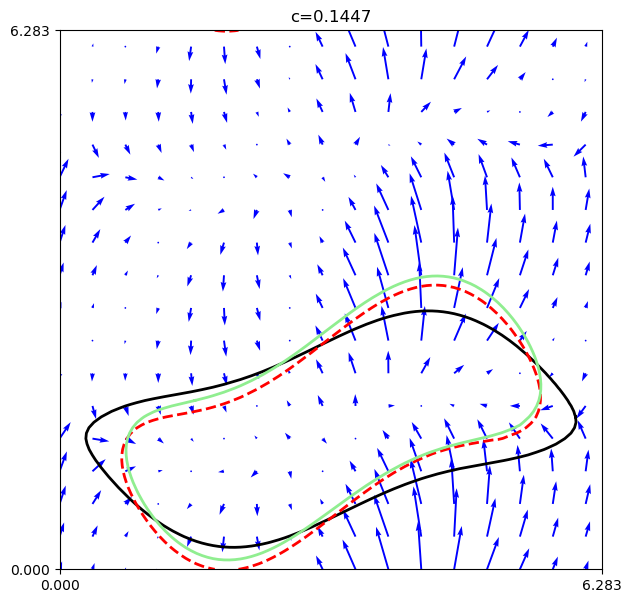

In [24]:
plt.figure(figsize=(7,7), dpi=100)
ax = plt.axes()
ax.set(xlim=(0,2π), ylim=(0,2π), xticks=(0,2π), yticks=(0,2π))
plot_vectorfield(get_levelset_evolution(ctx,u₀,u_dot,bdata=bdata)...,ax,scale=2,step=6)
curves           = lines(get_levelset(ctx, u₀, c_paper,bdata=bdata))
curves_epsilon   = lines(get_levelset(ctx, uϵ, c_paper,bdata=bdata))
curves_predicted = lines(get_levelset(ctx, u₀ + ϵ*u_dot, c_paper,bdata=bdata))

for c in curves
    ax.plot(coordinates(c)...,color=:black,linewidth=2)
end
for c in curves_epsilon
    ax.plot(coordinates(c)...,color=:red,linestyle="--",linewidth=2)
end
for c in curves_predicted
    ax.plot(coordinates(c)...,color=:lightgreen,linewidth=2)
end
ax.set_title("c=$(round(c_paper,digits=4))");